# Introduction

This notebook contain some of the code used for the final project in the course Personal Data Interaction for Mobile and Wearables 02808-F16 at the Technical University of Denmark. The notebook consists of 2 main areas: Detect public transportation and association analysis based on visited places. All client IDs and access tokens have been removed to respect privacy. <br><br>
<b>The Authors behind this notebook are:</b>
<ul>
    <li>Themi Tsiotas von Pfaler (s113603)</li>
    <li>Mikkel Ole Rømer (s113408)</li>
    <li>Jesper Bitsch Østergaard (s113730)</li>
</ul>

# Table of Contents
 <p><div class="lev1"><a href="#Introduction"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1"><a href="#Detect-public-transport"><span class="toc-item-num">2&nbsp;&nbsp;</span>Detect public transport</a></div><div class="lev2"><a href="#Formatting-data"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Formatting data</a></div><div class="lev2"><a href="#Find-the-public-transportation-which-is-the-most-similar"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Find the public transportation which is the most similar</a></div><div class="lev2"><a href="#Count-time-used"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Count time used</a></div><div class="lev2"><a href="#Take-your-bike-instead-+-other-fun-fact"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Take your bike instead + other fun fact</a></div><div class="lev2"><a href="#Most-common-routes"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Most common routes</a></div><div class="lev2"><a href="#Plot-the-difference-between-the-actual-points-and-the-snapped-to-road"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Plot the difference between the actual points and the snapped to road</a></div><div class="lev2"><a href="#Help-methods"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Help methods</a></div><div class="lev1"><a href="#Association-analysis"><span class="toc-item-num">3&nbsp;&nbsp;</span>Association analysis</a></div><div class="lev2"><a href="#Formatting-data"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Formatting data</a></div><div class="lev2"><a href="#Time-used-at-each-place"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Time used at each place</a></div><div class="lev2"><a href="#Look-at-the-timespan-you-are-for-a-given-place-according-to-the-rules"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Look at the timespan you are for a given place according to the rules</a></div><div class="lev2"><a href="#Apriori-for-all-days-(Not-divided-by-days)"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Apriori for all days (Not divided by days)</a></div><div class="lev2"><a href="#Help-methods"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Help methods</a></div><div class="lev2"><a href="#Implementation-of-the-Apriori-algorithm"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Implementation of the Apriori algorithm</a></div><div class="lev1"><a href="#Utils"><span class="toc-item-num">4&nbsp;&nbsp;</span>Utils</a></div><div class="lev2"><a href="#Code-to-connect-to-the-moves-API"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Code to connect to the moves API</a></div><div class="lev2"><a href="#Rejseplanen-(Journeyplanner)"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Rejseplanen (Journeyplanner)</a></div><div class="lev2"><a href="#RenderJSON"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>RenderJSON</a></div><div class="lev2"><a href="#Format-polyline-from-Googlemaps-API"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Format polyline from Googlemaps API</a></div><div class="lev2"><a href="#General-project-utils"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>General project utils</a></div>

**Import thirdparty modules**

In [73]:
import json, pip, googlemaps, operator, time, copy
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse  
from decimal import Decimal
from sklearn import linear_model, cross_validation
from pytz import timezone
from firebase import firebase
from itertools import groupby
from IPython.display import Image

%matplotlib inline

**Import custom modules**

In [72]:
from pythonscripts.formatpolyline import *
from pythonscripts.renderjson import RenderJSON
from pythonscripts.movesapi import Moves
from pythonscripts.projectutils import *
from pythonscripts.journeyplanner import JourneyPlannerAPI

In [ ]:
#CONSTANTS
gmaps_server = ""
firebase_url = ""

clientSecret_moves = "";
clientId_moves = "";
redirectUri_moves = "";

access_token_moves = ""
user_id = ""

**Generate Google maps API instance**

In [8]:
gmaps = googlemaps.Client(key=gmaps_server)

**Connect to firebase backend**

In [9]:
firebaseCon = firebase.FirebaseApplication(firebase_url, None)

**Generate the Moves API instance**

In [10]:
moves = Moves(clientId_moves,clientSecret_moves,redirectUri_moves,"https://api.moves-app.com/api/1.1")

Define the interval we want to load data for

In [90]:
data_interval = "all" #week, month, all

Now it is possible to load the places and summaries for the current user

In [ ]:
items_place_range = [] #Items set
summaries_range = []

ranges = [("2016-04-22","2016-04-29")] #week

if data_interval == "month":
    ranges = [("2016-04-01","2016-04-29")]
elif data_interval == "all":
    #Can only load a range of 31 days
    ranges = [("2016-03-02","2016-03-13"), ("2016-03-14","2016-04-13"),("2016-04-14","2016-04-29")]
    
for r in ranges:
    items_place_range += moves.get_range(access_token,"/user/places/daily",r[0],r[1])    
    summaries_range += moves.get_range(access_token,"/user/summary/daily",r[0],r[1])

print "Number of days: ", len(items_place_range)
print "Number of days with summary: ", len(summaries_range)

In [193]:
RenderJSON(items_place_range)

In [194]:
RenderJSON(summaries_range)

It is also possible to load storylines (Activities). Here we only load data for a single day. This code should run for each of the users each day.  

In [175]:
selected_date = "20160509"
one_day_storyline = moves.get_sotryline(access_token, selected_date)
one_day_summary = moves.get_summary(access_token, selected_date)

print "Keys in obj:", one_day_storyline[0].keys()
print "Number of travels the first day: ", len(one_day_storyline[0]["segments"])

Keys in obj: [u'date', u'lastUpdate', u'segments', u'summary']
Number of travels the first day:  16


In [43]:
RenderJSON(one_day_storyline)

# Detect public transport

## Formatting data

Start out by only taking the activities where we "move", not interested in "place" + altleast one movement should not be walking or cycling.

In [167]:
move_ac = []
for ac in one_day_storyline[0]["segments"]:
    if ac["type"] == "move" and any(x["activity"] != "walking" and x["activity"] != "cycling" for x in ac["activities"]):
        move_ac.append(ac)

print "Number of travels with transport: ",len(move_ac)

Number of travels with transport:  3


Now we get the snap to road data for each of the activities

In [168]:
for ac in move_ac:
    for sub_ac in ac["activities"]:
        temp_route = []
        for trackpoint in sub_ac["trackPoints"]:
            temp_route.append([float(trackpoint["lat"]),float(trackpoint["lon"])])
        
        #Maximun of 100 points. 
        if len(temp_route) > 100:
            #Divide the point into chunks with maximum 100 points in each
            chunks = chunkIt(temp_route, math.ceil(len(temp_route)/100.0))
            sub_ac["snapped_to_road"] = []
            for chunk in chunks:
                snapped_to_road =  gmaps.snap_to_roads(path=chunk)
                sub_ac["snapped_to_road"] += snapped_to_road
        else:
            snapped_to_road =  gmaps.snap_to_roads(path=temp_route)
            sub_ac["snapped_to_road"] = snapped_to_road #Now we also have the snapped to road coordinates

Adjust if there has not been a stop, but moves has splitted the data in two anyway. Here we use the 15 minute threshold as mentioned in the report. 

In [169]:
adjusted_activities = []
localtz = timezone('Europe/Copenhagen')
minute_threshold = 15

for i,ac in enumerate(move_ac):
    copy_ac = copy.deepcopy(ac)
    if i == 0:
        adjusted_activities.append(copy_ac)
    else:
        previous_activity = adjusted_activities[len(adjusted_activities)-1]
        end_time_previous = convertMovesDateToDatetime(previous_activity["endTime"],localtz)
        start_time_current = convertMovesDateToDatetime(ac["startTime"],localtz)
        
        time_diff =  start_time_current - end_time_previous
        minutes,seconds = divmod(time_diff.days * 86400 + time_diff.seconds, 60)
                    
        if minutes > minute_threshold:
            adjusted_activities.append(copy_ac)
        else:
            previous_activity["activities"] += list(copy_ac["activities"])
            previous_activity["endTime"] = copy_ac["endTime"]

In [74]:
RenderJSON(move_ac)

In [75]:
RenderJSON(adjusted_activities)

Get the suggestions for routes with public transportation from the Google API. The API will return 4 suggestions.

In [170]:
#Save the google suggestions for each of the activities. 
for j,activity in enumerate(adjusted_activities):
    suggestions_only_transport = findTranportationsForActivity(activity)
    adjusted_activities[j]["google_suggestions"] = suggestions_only_transport

In [76]:
def findTranportationsForActivity(selected_activity):
    #Use the actual start and end locations and not the snapped to road. 
    #This is due to the fact that the start and end locations from Moves are quite precise, and is therefore preffered. 
    key_name = "trackPoints"

    results = []
    #Go through each of the activities
    for sub_activity in selected_activity["activities"]:
        #If the activity is of type transport, we find suggestions. 
        if sub_activity["group"] == "transport":
            #define start and endtime. 
            start_time = convertMovesDateToDatetime(sub_activity["startTime"],localtz) - timedelta(minutes=5)
            end_time = convertMovesDateToDatetime(sub_activity["endTime"],localtz)
            
            #Define the start and end tuples send to Goolgle. 
            from_tuple = (sub_activity[key_name][0]["lat"],sub_activity[key_name][0]["lon"])
            to_tuple = (sub_activity[key_name][len(sub_activity[key_name])-1]["lat"],sub_activity[key_name][len(sub_activity[key_name])-1]["lon"])
            
            #Find the nearest station with the Journeyplanner. This station is used as the start location instead. 
            from_lon = str(from_tuple[1]).replace(".","")
            from_lat = str(from_tuple[0]).replace(".","")

            difflat = 8-len(from_lat)
            difflon = 8-len(from_lon)
            
            for k in range(difflat):
                from_lat += "0"
            for k in range(difflon):
                from_lon += "0"
            
            plannerClinet = JourneyPlannerAPI()
            
            nearbyResult = plannerClinet.stopsNearby(from_lon,from_lat,"1000","30")
            if len(nearbyResult) > 0:
                if "StopLocation" in nearbyResult["LocationList"]:
                    closests = nearbyResult["LocationList"]["StopLocation"][0]
                    from_tuple = (float(closests["y"])/float(1000000),float(closests["x"])/float(1000000))
            
            result = gmaps.directions(
                                    origin = from_tuple,
                                     destination = to_tuple,
                                     mode="transit", #driving", "walking", "bicycling" or "transit"
                                     departure_time = start_time,
                                    alternatives = True)
            results.append({
                    "activity" : sub_activity,
                    "results" : result
                })
            
    return results


## Find the public transportation which is the most similar

Now we can find the used public trasportation lines

In [171]:
likely_transportation = []

for j,activity in enumerate(adjusted_activities):    
    transport_result = checkIsPublicTransport(adjusted_activities[j]["google_suggestions"])
    likely_transportation += transport_result

2016-05-09 08:08:00+02:00 2016-05-09 08:54:00+02:00 3 6  E (Commuter train) 180 (Bus) 2760 20258
2016-05-09 08:15:00+02:00 2016-05-09 08:57:30+02:00 -4 2  A (Commuter train) 300S (Bus) 2550 20314
2016-05-09 08:18:00+02:00 2016-05-09 09:04:00+02:00 -7 -4  E (Commuter train) 180 (Bus) 2760 20258
2016-05-09 08:25:00+02:00 2016-05-09 09:07:30+02:00 -14 -8  A (Commuter train) 300S (Bus) 2550 20314

Actual:  2016-05-09 08:11:54+02:00 2016-05-09 09:00:19+02:00

2016-05-09 12:47:00+02:00 2016-05-09 12:56:39+02:00 4 2  300S (Bus) 579 2535
2016-05-09 12:46:00+02:00 2016-05-09 12:55:51+02:00 5 3  30E (Bus) 591 2426
2016-05-09 12:48:00+02:00 2016-05-09 12:59:29+02:00 3 0  181 (Bus) 689 2503
2016-05-09 12:53:00+02:00 2016-05-09 13:03:39+02:00 -2 -5  190 (Bus) 639 2733

Actual:  2016-05-09 12:51:00+02:00 2016-05-09 12:59:30+02:00

2016-05-09 13:12:00+02:00 2016-05-09 13:40:00+02:00 1 0  A (Commuter train) 1737 17759
2016-05-09 13:18:00+02:00 2016-05-09 13:48:00+02:00 -5 -8  E (Commuter train) 1857 1

In [79]:
# Check to see whether or not, the points are close enough to actual route = public transportation. 
def checkIsPublicTransport(data):
    sum_public_transport = []
    for sub_activity in data:
        
        #Get the actual route and googles suggested routes
        routes_google = getGoogleRoutes(sub_activity["results"])
        actual_route = getActualRoute(sub_activity["activity"])
        
        #Compare each of googles routes with the actual route
        distance_result = compareDistanceActualToGoogle(routes_google,actual_route)
        
        #Compare each of googles arrival/departure times with the actual 
        compare_time = compareArrivalDepartureToActual(sub_activity)
        
        public_transport = getMostlikelyRoute(compare_time, distance_result,sub_activity)
        
        if public_transport != None:
            #It is detected as public transportation. 
            sum_public_transport.append(public_transport)
            
    return sum_public_transport

Here are a couple of help methods to check whether or not the user used public transportation. 

In [78]:
def getGoogleRoutes(google_directions):
    """Format the polyline from the google suggestion"""
    routes_google = {}
    for i, suggestion in enumerate(google_directions): 
        routes_google[i] = []
        for step in suggestion["legs"][0]["steps"]:
            travel_mode = step["travel_mode"]
            poly = step["polyline"]["points"]
            points = decode_polyline(poly)
            for p in points:
                routes_google[i].append([float(p[1]),float(p[0])]) #lat, lon
                
    return routes_google

def getActualRoute(activity):
    """Get all the actual points/snapped to road points"""
    #key_name = "trackPoints"
    key_name = "snapped_to_road"
    
    actual_route = []
    for trackpoint in activity[key_name]:
        if key_name == "trackPoints":
            actual_route.append([float(trackpoint["lat"]),float(trackpoint["lon"])])
        else:
            actual_route.append([float(trackpoint["location"]["latitude"]),float(trackpoint["location"]["longitude"])])
            
    return actual_route

def compareDistanceActualToGoogle(google_routes,actual_route):
    """Compare the dinstance between google point and the acutal points"""
    distance_result = {}
    
    for key in google_routes:
        current_route = google_routes[key]

        distances = []
        # -- Compare the actual route to the route from google --
        for point in actual_route:
            temp_disantces = [distance_points(point[0],point[1],pp[0],pp[1]) for pp in current_route]
            distances.append(min(temp_disantces)) 

        # -- Compare the route from google to the actual route
        #for point in current_route:
        #    temp_disantces = [distance_points(point[0],point[1],pp[0],pp[1]) for pp in actual_route]
        #    distances.append(min(temp_disantces))

        #print max(distances), min(distances), np.mean(distances), np.median(distances)
        
        distance_result[key] = {
            "max" : max(distances),
            "min" : min(distances),
            "mean" : np.mean(distances),
            "median" : np.median(distances)
        }

    return distance_result
    
def compareArrivalDepartureToActual(data):
    """Compare arrival and depature with the actual data"""
    actual_data = data["activity"]
    localtz = timezone('Europe/Copenhagen')
    start_time = convertMovesDateToDatetime(actual_data["startTime"],localtz)
    end_time = convertMovesDateToDatetime(actual_data["endTime"],localtz)
    
    rtnobj = []
    for i, suggestion in enumerate(data["results"]): 
        sugg = suggestion["legs"][0]
        
        if  "departure_time" not in sugg:
            #NO DEPARTURE TIME == NOT PUBLIC TRANSPORT
            continue

        lines = []
        lines_txt = ""
        
        departure_time = None
        for step in  sugg["steps"]:
            if step["travel_mode"] == "TRANSIT":
                transit_details = step["transit_details"]
                if departure_time == None:
                    #Set the first departure time for a transit to the actual departure time..
                    #We know that we start a transport travel at the given time, so we are not interested in the first walk. 
                    dt_unaware_departure_temp = datetime.utcfromtimestamp(float(transit_details["departure_time"]["value"]))
                    departure_time = localtz.fromutc(dt_unaware_departure_temp)
                    
                lines_txt += " " + transit_details["line"]["short_name"] + " ("+transit_details["line"]["vehicle"]["name"]+")"
                lines.append({
                        "line_name" : transit_details["line"]["short_name"],
                        "type_name" : transit_details["line"]["vehicle"]["type"],
                        "name" : transit_details["line"]["vehicle"]["name"],
                        "duration_seconds" : step["duration"]["value"],
                        "distance_meters" : step["distance"]["value"]
                    })
        
        dt_unaware_departure = datetime.utcfromtimestamp(float(sugg["departure_time"]["value"]))
        dt_unaware_arrival = datetime.utcfromtimestamp(float(sugg["arrival_time"]["value"]))

        arrival_time = localtz.fromutc(dt_unaware_arrival)

        time_diff_start =  start_time - departure_time
        time_diff_end =  end_time - arrival_time

        minutes_s,seconds_s = divmod(time_diff_start.days * 86400 + time_diff_start.seconds, 60)
        minutes_e,seconds_e = divmod(time_diff_end.days * 86400 + time_diff_end.seconds, 60)
        
        
        rtnobj.append({
            "google_suggestion_key" : i,
            "departure" : departure_time,
            "arrival" : arrival_time,
            "diff_minutes_departure" : abs(minutes_s),
            "diff_minutes_arrival" : abs(minutes_e),
            "total_diff" :  abs(minutes_s) + abs(minutes_e),
            "lines_txt" : lines_txt,
            "lines" : lines,
            "duration_seconds" : sugg["duration"]["value"],
            "distance_meters" : sugg["distance"]["value"]
        })
        print departure_time, arrival_time, minutes_s, minutes_e, lines_txt, sugg["duration"]["value"], sugg["distance"]["value"]
    
    print ""   
    print "Actual: ", start_time, end_time
    print ""
    
    rtnobj.sort(key=lambda x: (x["diff_minutes_departure"],x["diff_minutes_arrival"],x["total_diff"]), reverse=False)

    return rtnobj
    
def getMostlikelyRoute(timedata, distancedata,rawdata):
    #We know that the timedata is ordered with the one with the lowest time difference first. 
    #So we check if the time difference is more than 5 minutes. If it is. We reject that it is public transport. 
    if len(timedata) == 0:
        return None
    if timedata[0]["diff_minutes_departure"] > 5:
        return None
    
    likely_route = None
    
    for suggestion in timedata:
        distance_for_result = distancedata[suggestion["google_suggestion_key"]]
        min_median_mean = min([distance_for_result["median"],distance_for_result["mean"]])
        
        if min_median_mean < 0.1 and suggestion["diff_minutes_departure"] < 5:
            likely_route = suggestion
            break

    return likely_route

## Count time used

Now we can look at how much time we have used in each of the transportation types. 

In [172]:
transportation_types = {}

for transportation in likely_transportation:
    for line in transportation["lines"]:
        t_type = line["type_name"]
        line_name = line["line_name"]
        time_spent = line["duration_seconds"]
        distance = line["distance_meters"]
        name = line["name"]
        if "train" in name:
            name = "Train"
    
        if t_type not in transportation_types:
            transportation_types[t_type] = {}
        if line_name not in transportation_types[t_type]:
            transportation_types[t_type][line_name] = []

        transportation_types[t_type][line_name].append({
                "time_seconds" : time_spent,
                "distance_meters" : distance,
                "name" : name
            })
    
    
        print t_type, line_name, time_spent,"seconds", distance, "meters"

COMMUTER_TRAIN E 1680 seconds 17676 meters
BUS 180 480 seconds 2440 meters
COMMUTER_TRAIN A 1680 seconds 17678 meters


Now we can calculate some of the stats shown to the user

In [179]:
time_fb_obj = {}
distance_fb_obj = {}

In [180]:
#Get the walking and cycling activities. 
for summary in one_day_summary[0]["summary"]:
    if summary["activity"] in ["cycling","walking"]:
        name = summary["activity"]
        minutes = summary["duration"]
        distance = summary["distance"]
        
        stat_time = {
            "Number" : minutes,
            "Metric" : "min.",
            "Description" : "spent in "+name,
            "statType" : "TravelTime",
            "TravelType" : "PublicTransport"
        }

        stat_distance = {
            "Number" : distance/float(1000),
            "Metric" : "km",
            "Description" : "travelled by "+name,
            "statType" : "TravelDistance",
            "TravelType" : "PublicTransport"
        }
        time_fb_obj[name] = stat_time
        distance_fb_obj[name] = stat_distance        


In [183]:
for t_type in transportation_types:
    
    total_time_sum = 0
    total_distance_sum = 0
    name = None
    for line_name in transportation_types[t_type]:
        total_time_sum += sum([x["time_seconds"] for x in transportation_types[t_type][line_name]])
        total_distance_sum += sum([x["distance_meters"] for x in transportation_types[t_type][line_name]])
        name = transportation_types[t_type][line_name][0]["name"]
    
    m, s = divmod(total_time_sum, 60)
    
    stat_time = {
        "Number" : m,
        "Metric" : "min.",
        "Description" : "spent in "+name,
        "statType" : "TravelTime",
        "TravelType" : "PublicTransport"
    }
    #fb_main_time["stats"].append(stat_time)
    stat_distance = {
        "Number" : total_distance_sum/float(1000),
        "Metric" : "km",
        "Description" : "travelled by "+name,
        "statType" : "TravelDistance",
        "TravelType" : "PublicTransport"
    }
    #fb_main_distance["stats"].append(stat_distance)
    time_fb_obj[name] = stat_time
    distance_fb_obj[name] = stat_distance
    h, m = divmod(m, 60)

    print "+++++ "+t_type+" +++++"
    print "%d:%02d:%02d" % (h, m, s)
    print str(total_distance_sum/float(1000)) + " km"
    print ""

+++++ BUS +++++
0:08:00
2.44 km

+++++ COMMUTER_TRAIN +++++
0:56:00
35.354 km



In [ ]:
#save stats to firebase
result = firebaseCon.post('/users/'+user_id+"/stats/time/"+selected_date,time_fb_obj)
result = firebaseCon.post('/users/'+user_id+"/stats/distance/"+selected_date,distance_fb_obj)

## Take your bike instead + other fun fact

In [83]:
def findPossibleRoutesWithBike(selected_activity):
    key_name = "trackPoints"
    results = []
    
    for sub_activity in selected_activity["activities"]:
        if sub_activity["group"] == "transport" and sub_activity["distance"] < 30000:
            start_time = convertMovesDateToDatetime(sub_activity["startTime"],localtz)
            end_time = convertMovesDateToDatetime(sub_activity["endTime"],localtz)
                        
            from_tuple = (sub_activity[key_name][0]["lat"],sub_activity[key_name][0]["lon"])
            to_tuple = (sub_activity[key_name][len(sub_activity[key_name])-1]["lat"],sub_activity[key_name][len(sub_activity[key_name])-1]["lon"])
                        
            result = gmaps.directions(
                                     origin = from_tuple,
                                     destination = to_tuple,
                                     mode="bicycling")
            results.append({
                    "activity" : sub_activity,
                    "results" : result
                })
            
    return results

In [185]:
#Get the cycling routes for the transport...
for j,activity in enumerate(adjusted_activities):
    suggestions_only_transport = findPossibleRoutesWithBike(activity)
    adjusted_activities[j]["google_suggestions_bike"] = suggestions_only_transport

In [186]:
#Compare time...
diff_seconds = 0
for j,activity in enumerate(adjusted_activities):
    transport_time_total = 0
    cycling_time_total = 0
    
    for i,sub_activity in enumerate(activity["google_suggestions_bike"]):
        
        bike_result = sub_activity["results"][0]["legs"][0]
        transport_result = activity["google_suggestions"][i]["activity"]
        
        seconds_transport = transport_result["duration"]
        seconds_bycyling = bike_result["duration"]["value"]
        print "Seconds in transport: ",seconds_transport, "Seconds on bike: ",seconds_bycyling, transport_result["activity"]
        diff_seconds += (seconds_bycyling-seconds_transport)
        
print "Total diff in seconds: ", diff_seconds
print "Total diff in minutes: ", round(diff_seconds * 0.0166666667,0)

Seconds in transport:  2905.0 Seconds on bike:  3580 transport
Seconds in transport:  510.0 Seconds on bike:  560 transport
Seconds in transport:  1611.0 Seconds on bike:  3148 transport
Total diff in seconds:  2262.0
Total diff in minutes:  38.0


In [ ]:
minutes_diff = round(diff_seconds * 0.0166666667,0)
fb_obj = {"type" : "cycling", "number" : minutes_diff}
result = firebaseCon.post('/users/'+user_id+"/stats/fun/"+selected_date,fb_obj)

## Most common routes
Now it is time to look at the most common routes a user take

In [87]:
#check the unqieu places for the user
for place in places_dict:
    print place, places_dict[place]["lat"], places_dict[place]["lon"]

Københavns Hovedbanegård 55.6720682498 12.565266912
DTU Bibliotek 55.7853973718 12.5235733461
Herningvej 93, 6950 Ringkøbing, Denmark 56.087016 8.2742586
Nordisk Film Biografer Palads 55.6764107 12.5636902
Fakta - Holstebrovej Ringkøbing 56.10425 8.25701
Fisketorvet Shopping Center 55.66273 12.56147
Valby-Hallen 55.6494444444 12.5163888889
Dgi-Byen, Vandkulturhuset 55.6696714563 12.5647833008
Halifax Skolegade 55.66548 12.51353
Madumvej 8, 6990 Ulfborg, Denmark 56.238199 8.2925072
Norsmindevej 15, 8340 Malling, Denmark 56.03746 10.236526
Egerisvej 13, 6900 Skjern, Denmark 55.994853 8.6176699
Faksegade 8A, 2100 København Ø, Denmark 55.699769 12.581255
Østerdige 11 56.0838 8.26276
Reventlowsgade 7, 1651 København V, Denmark 55.672646 12.564683
Gymnasiet HTX Skjern 55.9414050306 8.51543339539
Isagervej 1, 6950 Ringkøbing, Denmark 56.093488 8.266952
Adapt Mobile 55.6702336095 12.5859698454
Musvitvej 3 56.088 8.26486
Hindbærvej 2, 6950 Ringkøbing, Denmark 56.092471 8.2712659
IN AND OUT - Ho

The following are a couple of help methods

In [153]:
def findToFromPrDay(day_str):
    """Find all travels between places for a given day"""
    
    #Load the one day storyline
    one_day_storyline = moves.get_sotryline(access_token, day_str)
    
    #Again format the data and only take the ones we need
    move_ac = []

    if len(one_day_storyline) == 0 or type(one_day_storyline) != list:
        return []

    if one_day_storyline[0]["segments"]  == None:
        return []

    for ac in one_day_storyline[0]["segments"]:
        if ac["type"] == "move" and any(x["activity"] != "walking" and x["activity"] != "cycling" for x in ac["activities"]):
            move_ac.append(ac)
    
    adjusted_activities = adjust_activities(move_ac)
    
    from_to_list = []
    
    for j,activity in enumerate(adjusted_activities):
        #find start and endpoints
        start_p, end_p = findStartAndEndpoint(activity)
        
        from_to_list.append({
                "from" : start_p,
                "to" : end_p,
                "from_loc" : findNearestPlace(start_p),
                "to_loc" : findNearestPlace(end_p)
            })
        
    return from_to_list

def findNearestPlace(location):
    """Find the nearest place for a given coordinate point"""
    distance = float('inf')
    rtnObj = None
    rtnName = None
    for key in places_dict:
        sub_loc = places_dict[key]
        
        distance_temp = distance_points(sub_loc["lat"], sub_loc["lon"],location[0] , location[1])
        if distance > distance_temp:
            distance = distance_temp
            rtnObj = sub_loc
            rtnName = key
    
    return rtnObj, rtnName
            
def findStartAndEndpoint(selected_activity):
    """Extract the start and endpoint from a Moves activity"""
    results = []
    key_name = "trackPoints"
    
    f_activity  = selected_activity["activities"][0]
    l_activity  = selected_activity["activities"][len(selected_activity["activities"])-1]    
    
        
    from_tuple = (f_activity[key_name][0]["lat"],f_activity[key_name][0]["lon"])
    to_tuple = (l_activity[key_name][len(l_activity[key_name])-1]["lat"],l_activity[key_name][len(l_activity[key_name])-1]["lon"])
    
    return from_tuple, to_tuple

def adjust_activities(move_ac):
    """Adjust if there has not been a stop, but moves has splitted the data in two anyway"""
    adjusted_activities = []
    for i,ac in enumerate(move_ac):

        copy_ac = copy.deepcopy(ac)
        if i == 0:
            adjusted_activities.append(copy_ac)
        else:
            previous_activity = adjusted_activities[len(adjusted_activities)-1]
            end_time_previous = convertMovesDateToDatetime(previous_activity["endTime"],localtz)
            start_time_current = convertMovesDateToDatetime(ac["startTime"],localtz)

            time_diff =  start_time_current - end_time_previous
            minutes,seconds = divmod(time_diff.days * 86400 + time_diff.seconds, 60)

            if minutes > 15:
                adjusted_activities.append(copy_ac)
            else:
                previous_activity["activities"] += list(copy_ac["activities"])
                previous_activity["endTime"] = copy_ac["endTime"]
                
    return adjusted_activities

In [163]:
#Generate data string for the selected period
count_from_to = {} 
dates_list = []
if data_interval == "week":
    for i in range(22,30):
        day_str = data_pre+str(i)
        dates_list.append(day_str)
elif data_interval == "month":
    for i in range(1,30):
        day_str = data_pre+str(i)
        dates_list.append(day_str)        
elif data_interval == "all":
    for data_pre in ["201603","201604"]:
        for i in range(1,31):
            day_str = data_pre+str(i)   
            dates_list.append(day_str)
    
for day_str in dates_list:
    from_to_pr_day = findToFromPrDay(day_str)
    for travel in from_to_pr_day:
        #generate key by combining the two locations
        travel_key = travel["from_loc"][1] + "_" + travel["to_loc"][1]
        if travel["from_loc"][1] > travel["to_loc"][1]:
            travel_key = travel["to_loc"][1] + "_" + travel["from_loc"][1]

        if travel_key not in count_from_to:
            count_from_to[travel_key] = 1
        else: 
            count_from_to[travel_key] += 1

In [164]:
#sort the dictionary by value, and get the most travelled routes. 
sorted_count_from_to = sorted(count_from_to.items(), key=operator.itemgetter(1), reverse=True)
for pl in sorted_count_from_to[:3]:
    print pl[0].split("_"), pl[1]

[u'Dtu 324', u'Home'] 19
[u'Dgi-Byen, Vandkulturhuset', u'Home'] 17
[u'Musvitvej 3', u'\xd8sterdige 11'] 14


This data can be saved to firebase

In [165]:
fb_main = {
    "name" : "Most Used",
    "statType" : "MostUsed",
    "stats" : []
}   

for obj in sorted_count_from_to[:3]:
    locA, locB =  obj[0].split("_")
        
    firebase_obj = {
        "number" : obj[1],
        "metric" : "times",
        "description" : "you have travel between "+locA+" and "+locB,
        "statType" : "MostUsed"
    }
    fb_main["stats"].append(firebase_obj)

result = firebaseCon.post('/users/'+user_id+"/stats/"+data_interval,fb_main)

## Plot the difference between the actual points and the snapped to road
The following is just an example which shows what influence the snap to road function has

In [ ]:
geo_data_for_plotting_snapped = {
    "lat" : [],
    "lon" : []
}
geo_data_for_plotting_actual = {
    "lat" : [],
    "lon" : []
}

activity = adjusted_activities[0]
for sub_ac in activity["activities"]:
    for trackpoint in sub_ac["trackPoints"]:
        geo_data_for_plotting_actual["lat"].append(float(trackpoint["lat"]))
        geo_data_for_plotting_actual["lon"].append(float(trackpoint["lon"]))
                                                   
    for trackpoint in sub_ac["snapped_to_road"]:
        geo_data_for_plotting_snapped["lat"].append(float(trackpoint["location"]["latitude"]))
        geo_data_for_plotting_snapped["lon"].append(float(trackpoint["location"]["longitude"]))

In [ ]:
geo_data_for_plotting_snapped = {
    "lat" : [],
    "lon" : []
}
geo_data_for_plotting_actual = {
    "lat" : [],
    "lon" : []
}

#Select an activity to display
activity = adjusted_activities[0]
sub_ac = activity["activities"][2]

for trackpoint in sub_ac["trackPoints"]:
    geo_data_for_plotting_actual["lat"].append(float(trackpoint["lat"]))
    geo_data_for_plotting_actual["lon"].append(float(trackpoint["lon"]))

for trackpoint in sub_ac["snapped_to_road"]:
    geo_data_for_plotting_snapped["lat"].append(float(trackpoint["location"]["latitude"]))
    geo_data_for_plotting_snapped["lon"].append(float(trackpoint["location"]["longitude"]))

In [ ]:
#Generating the borders of the plot
north = max([max(geo_data_for_plotting_snapped["lat"]),max(geo_data_for_plotting_actual["lat"])])
west = min([min(geo_data_for_plotting_snapped["lon"]),min(geo_data_for_plotting_actual["lon"])])
south = min([min(geo_data_for_plotting_snapped["lat"]),min(geo_data_for_plotting_actual["lat"])])
east = max([max(geo_data_for_plotting_snapped["lon"]),max(geo_data_for_plotting_actual["lon"])])

print "North", north
print "West", west
print "South", south
print "East", east

bbox = BoundingBox(north=north, west=west, south=south, east=east)

In [ ]:
#Plot the map with the dots
geoplotlib.set_bbox(bbox)
geoplotlib.dot(geo_data_for_plotting_snapped,color="blue",point_size=4)
geoplotlib.dot(geo_data_for_plotting_actual,color="red",point_size=4)
geoplotlib.inline()

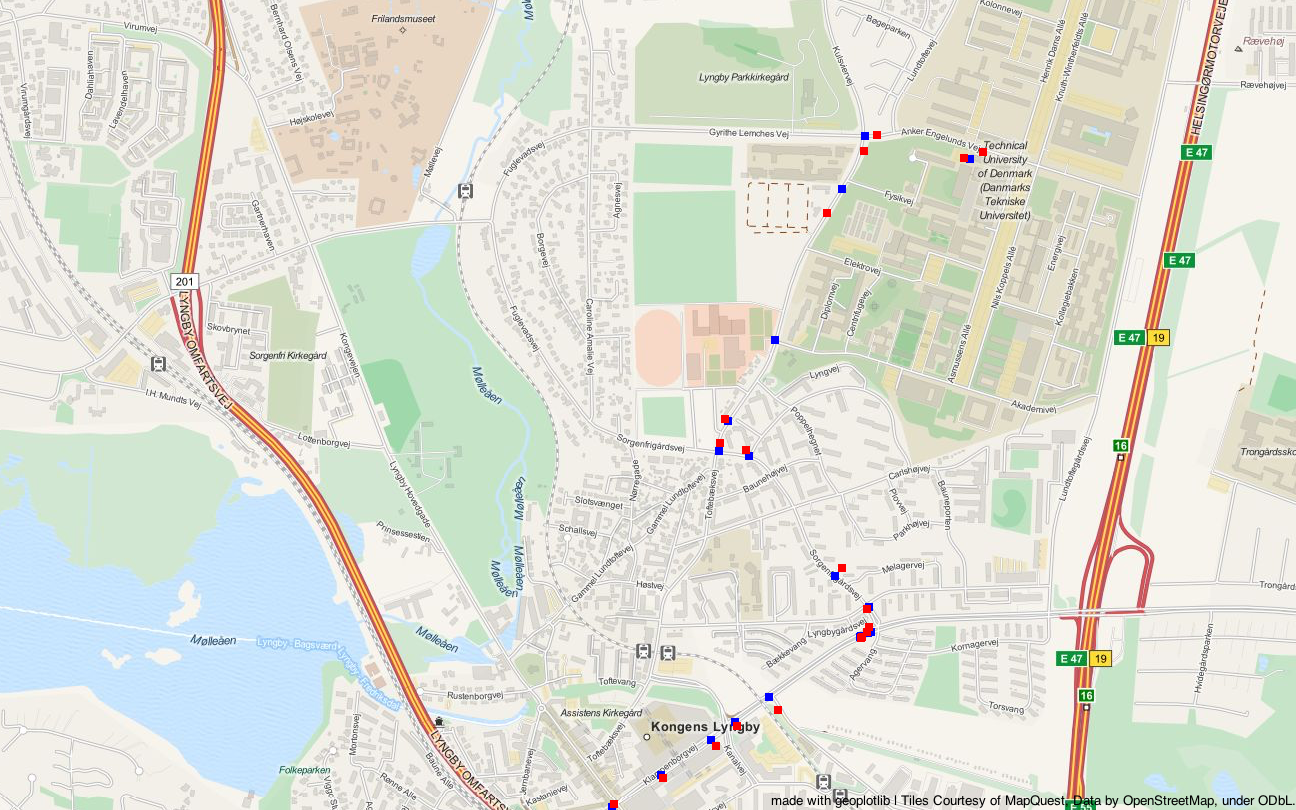

In [74]:
#The following is the generated image
Image(filename='snaptoroad.png')

## Help methods

In [41]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

# Association analysis

## Formatting data
The places you have been during a day is being transformed to a list, which is added to the corresponding day in the dictionary. 

In [37]:
items_by_day = {
    0 : [], #monday
    1 : [], #tuesday
    2 : [], #wednesday
    3 : [], #thursday
    4 : [], #friday
    5 : [], #saturday
    6 : [] #sunday
}

locations_to_compare = []

time_pr_place = {}

arrival_times_grouped_by_place = {}
places_dict = {}

apriori_all_days = []

places_list = []
index = 0

In [38]:
for day in items_place_range:
    #If the segments is not a list or day is equal to error, there has not been any places for that given day. 
    if day == "error" or type(day["segments"]) != list:
        continue
    
    startTimeDay = parse(day["date"])
    weekday = getWeekdayName(startTimeDay.weekday())

    temp_places_set = set()
    
    for i,segment in enumerate(day["segments"]):
        place = segment["place"]
        startTime = parse(segment["startTime"])
        endTime = parse(segment["endTime"])
        
        time_diff =  endTime - startTime
        minutes,seconds = divmod(time_diff.days * 86400 + time_diff.seconds, 60)
        
        #check the 15 minute time barrier
        if minutes > 15:
            place_name = get_place_name(locations_to_compare,place)
            
            lat = place["location"]["lat"]
            lon = place["location"]["lon"]
                
            temp_places_set.add(place_name)
            
            #Time pr place
            if place_name not in time_pr_place:
                time_pr_place[place_name] = {}
                
            time_pr_place[place_name][str(startTime)] = time_diff 
            
            #For association analysis
            if place_name not in arrival_times_grouped_by_place:
                arrival_times_grouped_by_place[place_name] = {}
               
            if place_name not in places_dict:
                places_dict[place_name] = {"lat" : lat, "lon" : lon}
            
            obj = {
                "start" : startTime,
                "end" : endTime,
                "day" : startTime.weekday(),
                "place_index" : index,
                "lat" : lat, 
                "lon" : lon,
                "name" : place_name
            } 
            arrival_times_grouped_by_place[place_name][str(startTime)] = obj
            places_list.append(obj)
            index += 1
            #For all days evaluation
            temp_places_set.add(place_name)
    
    items_by_day[startTimeDay.weekday()].append(temp_places_set)
    apriori_all_days.append(temp_places_set)   

Method which gets the place name for a Moves API *place*

In [20]:
def get_place_name(locations_to_compare,place):
    """Returns the name from a location. Either from entered with Moves or with the Google API"""
    place_name = ""
    lat = place["location"]["lat"]
    lon = place["location"]["lon"]
    if "name" not in place:
        #Name not entered with moves..
        min_distance = 0.10 #100 meters

        index_cloests = -1
        closests_distance = float('inf')

        for j,loc in enumerate(locations_to_compare):
            temp_lat = loc["lat"]
            temp_lon = loc["lon"]        
            distance = distance_points(lat, lon, temp_lat, temp_lon)
            if distance < min_distance and distance < closests_distance:
                closests_distance = distance
                index_cloests = j

        if index_cloests == -1:
            gmapsResult = gmaps.reverse_geocode((lat, lon))
            place_name = gmapsResult[0]["formatted_address"]
            locations_to_compare.append({
                    "lat" : lat,
                    "lon" : lon,
                    "name" : place_name
                })
        else:
            lat = locations_to_compare[index_cloests]["lat"]
            lon = locations_to_compare[index_cloests]["lon"]
            place_name = locations_to_compare[index_cloests]["name"]       
    else:
        #Name manually entered with moves
        place_name = place["name"]
        locations_to_compare.append({
            "lat" : lat,
            "lon" : lon,
            "name" : place_name
        })
    
    return place_name

Example data for a Tuesday

In [20]:
for row in items_by_day[1]:
    print row

set([u'Home', u'Dtu 324', u'Valby-Hallen'])
set([u'Home', u'Dtu 324', u'Valby-Hallen'])
set([u'Home', u'Valby-Hallen', u'SuperBrugsen Sydhavnen'])
set([u'Home', u'Dtu 324', u'Valby-Hallen'])
set([u'Valby-Hallen', u'Home', u'DTU Bibliotek', u'It Minds', u'Dtu 324'])
set([u'Home', u'Valby-Hallen'])
set([u'Home', u'Dtu 324', u'It Minds', u'Valby-Hallen'])
set([u'Home', u'Dgi-Byen, Vandkulturhuset', u'Dtu 324'])


Example rules for a Tuesday

In [50]:
ca = CustomApriori()
minSupport = 0.5
minConfidence = 0.6
items, rules = ca.runApriori(items_by_day[1], minSupport, minConfidence)
ca.printResults(items,rules)

item: (u'Dtu 324', u'Valby-Hallen') , 0.625
item: (u'Home', u'Dtu 324', u'Valby-Hallen') , 0.625
item: (u'Dtu 324',) , 0.750
item: (u'Home', u'Dtu 324') , 0.750
item: (u'Valby-Hallen',) , 0.875
item: (u'Home', u'Valby-Hallen') , 0.875
item: (u'Home',) , 1.000

------------------------ RULES:
Rule: (u'Home',) ==> (u'Dtu 324', u'Valby-Hallen') , 0.625
Rule: (u'Valby-Hallen',) ==> (u'Dtu 324',) , 0.714
Rule: (u'Valby-Hallen',) ==> (u'Home', u'Dtu 324') , 0.714
Rule: (u'Home', u'Valby-Hallen') ==> (u'Dtu 324',) , 0.714
Rule: (u'Home',) ==> (u'Dtu 324',) , 0.750
Rule: (u'Dtu 324',) ==> (u'Valby-Hallen',) , 0.833
Rule: (u'Dtu 324',) ==> (u'Home', u'Valby-Hallen') , 0.833
Rule: (u'Home', u'Dtu 324') ==> (u'Valby-Hallen',) , 0.833
Rule: (u'Home',) ==> (u'Valby-Hallen',) , 0.875
Rule: (u'Dtu 324',) ==> (u'Home',) , 1.000
Rule: (u'Valby-Hallen',) ==> (u'Home',) , 1.000
Rule: (u'Dtu 324', u'Valby-Hallen') ==> (u'Home',) , 1.000


## Time used at each place

In [39]:
time_in_minutes_pr_place = []

for place in time_pr_place:
    deltas = time_pr_place[place]
    total_delta = timedelta() 
    
    for key in deltas:
        sub_delta = deltas[key]
        total_delta += sub_delta
    
    da,hr,mi = days_hours_minutes(total_delta)
    time_in_minutes_pr_place.append({
        "minutes" : mi,
        "days" : da,
        "hours" : hr,
        "place" : place
    })

Sort the array 

In [198]:
time_in_minutes_pr_place.sort(key=lambda x: (x["days"], x["hours"],x["minutes"]), reverse=True)
for obj in time_in_minutes_pr_place:
    print obj["place"] +": ", obj["days"], obj["hours"], obj["minutes"]

Home:  31 11 29
Østerdige 11:  7 10 38
Dtu 324:  2 22 21
Musvitvej 3:  1 19 31
Valby-Hallen:  1 16 24
It Minds:  1 11 3
Egerisvej 13, 6900 Skjern, Denmark:  0 17 2
Dgi-Byen, Vandkulturhuset:  0 10 35
Hindbærvej 2, 6950 Ringkøbing, Denmark:  0 8 40
Farmor:  0 7 7
Skavenvej 34, 6880 Tarm, Denmark:  0 6 57
Gymnasiet HTX Skjern:  0 6 40
Vagn Aa. Jeppesens Vej, 2800 Kongens Lyngby, Denmark:  0 5 51
Bastard Café - kaffe, øl og masser af brætspil:  0 4 11
ROFI-Centret:  0 3 23
Nordisk Film Biografer Palads:  0 2 54
Norsmindevej 15, 8340 Malling, Denmark:  0 2 30
Faksegade 8A, 2100 København Ø, Denmark:  0 2 22
Fisketorvet Shopping Center:  0 1 49
Isagervej 1, 6950 Ringkøbing, Denmark:  0 1 44
Madumvej 8, 6990 Ulfborg, Denmark:  0 1 37
Halifax Skolegade:  0 1 36
Adapt Mobile:  0 1 10
DTU Bibliotek:  0 0 45
Københavns Hovedbanegård:  0 0 38
IN AND OUT - House Doctor:  0 0 37
Fakta - Holstebrovej Ringkøbing:  0 0 31
Reventlowsgade 7, 1651 København V, Denmark:  0 0 29
SuperBrugsen Sydhavnen:  0 

**Save the interesting data to firebase**

In [40]:
fb_data = {
    "name" : "Locations",
    "statType" : "TimeAtPlace",
    "stats" : []
}

#procent of days you are here ...
rules_by_day = {}
for i,day in enumerate(items_by_day): #Loop through each weekday
    #generate the rules
    ca = CustomApriori()
    minSupport = 0.5
    minConfidence = 0.6
    items, rules = ca.runApriori(items_by_day[day], minSupport, minConfidence)
    weekday_name = getWeekdayName(i)

    item_dict = {}
    
    for sub_item in items:
        for place in sub_item[0]:
            if place != "Home": #In this case we do not look at home.
                if place not in item_dict or (sub_item[1]*100) > item_dict[place]:
                    item_dict[place] = sub_item[1] * 100
                
    if len(item_dict) > 0:
        for key in item_dict:
            firebase_obj = {
                "number" : item_dict[key],
                "metric" : "%",
                "eventName" : key,
                "weekday" : weekday_name,
                "description" : "of all "+ weekday_name +" you are at "+key,
                "statType" : "EachDay",            
            }
            fb_data["stats"].append(firebase_obj)
            
            
#How much time spent
time_in_minutes_pr_place.sort(key=lambda x: (x["days"], x["hours"],x["minutes"]), reverse=True)
for obj in time_in_minutes_pr_place[:3]:
    metric_name = "days"
    metric_number = obj["days"]
    if metric_number == 0 and obj["hours"] != 0:
        metric_name = "hours"
        metric_number = obj["hours"]
    elif metric_number == 0:
        metric_name = "minutes"
        metric_number = obj["minutes"]
        
    firebase_obj = {
        "number" : metric_number,
        "metric" : metric_name,
        "eventName" : obj["place"],
        "description" : "Spent at "+obj["place"],
        "statType" : "TimeAtPlace",
    }
    fb_data["stats"].append(firebase_obj)

In [ ]:
result = firebaseCon.post('/users/'+user_id+'/stats/'+data_interval,fb_data)

## Look at the timespan you are for a given place according to the rules

First we generate a dictionary with rules for each weekday

In [75]:
rules_by_day = {}

for i,day in enumerate(items_by_day):
    ca = CustomApriori()
    minSupport = 0.5
    minConfidence = 0.6
    items, rules = ca.runApriori(items_by_day[day], minSupport, minConfidence)
    
    item_set = set()
    
    for sub_item in items:
        for place in sub_item[0]:
            if place != "Home":
                item_set.add(place)
                
    if len(item_set) > 0:
        rules_by_day[day] = item_set 

In [76]:
rules_g_by_day_to_firebase = {
    "Monday" : [],
    "Tuesday" : [],
    "Wednesday" : [],
    "Thursday" : [],
    "Friday" : [],
    "Saturday" : [],
    "Sunday" : []
}

def get_key_date_time_key(d):
    k = d + timedelta(minutes=-(d.minute % 60)) #Modulus the time in minutes.
    return datetime(k.year, k.month, k.day, k.hour, k.minute, 0)

def getObj(dt):
    obj = {
        "minute" : dt.minute,
        "hour" : dt.hour,
        "minute_str" : dt.strftime("%M"),
        "hour_str" : dt.strftime("%H")
    }
    return obj

The next peace of code is a bit long, but in short, this is the steps:
<ol>
    <li>Loop through each weekday</li>
    <li>Get all rules/places for that weekday, and loop through those</li>
    <li>Find all the arrivals for the given place for the corresponding weekday</li>
    <li>Check the data to see whether or not it need to be merged. Thresholds on 30 min. and 200 meters</li>
    <li>Group the arrivals in 20 minute intervals</li>
    <li>Find the max and min arrival/departure for each of the groups if they have more than 1 member</li>
</ol>

In [80]:
for day in rules_by_day: #For each weekday
    rules_this_day = rules_by_day[day] #For each rule/place pr. weekday..
    for day_rule in rules_this_day:
        #Get all arrivals for the given place
        arrivals_place = arrival_times_grouped_by_place[day_rule]
        arrivals_for_day = []
        #Find all arrivals for the place on the current weekday. 
        for arrival_time in arrivals_place:
            obj = arrivals_place[arrival_time]
            if obj["day"] == day:
                arrivals_for_day.append(obj)
                
        
        #Check to see if there has been some small breaks at a place == several activities on the same day. For exmaple go buying something another 
        #place at dtu
        arrival_dates_temp = {}
        for aa in arrivals_for_day:
            #Generates key for the day, in the format yyyy-mm-dd
            temp_key = str(aa["start"].date())
            
            if temp_key not in arrival_dates_temp:
                arrival_dates_temp[temp_key] = aa
            else:
                #If the key excists, we need to compare the two activities to find out which of them that was the first
                #We set a threshold to 30 minutes between the two dates end and start time and the distance to the intermediate place to 200 meters. 
                time_diff = None
                new_start = None
                new_end = None
                diff_distance = None
                
                if aa["start"] >= arrival_dates_temp[temp_key]["start"]:
                    time_diff =  aa["start"] - arrival_dates_temp[temp_key]["end"]
                    new_start = arrival_dates_temp[temp_key]["start"]
                    new_end = aa["end"]

                    lat1, lon1 = arrival_dates_temp[temp_key]["lat"],arrival_dates_temp[temp_key]["lon"]
                    lat2, lon2 = places_list[arrival_dates_temp[temp_key]["place_index"]+1]["lat"],places_list[arrival_dates_temp[temp_key]["place_index"]+1]["lon"]
                    diff_distance = distance_points(lat1,lon1,lat2,lon2)
                elif aa["start"] < arrival_dates_temp[temp_key]["start"]:
                    time_diff = arrival_dates_temp[temp_key]["start"] - aa["end"]
                    new_start = aa["start"]
                    new_end = arrival_dates_temp[temp_key]["end"]
                    
                    lat1, lon1 = aa["lat"],aa["lon"]
                    lat2, lon2 = places_list[aa["place_index"]+1]["lat"],places_list[aa["place_index"]+1]["lon"]
                    diff_distance = distance_points(lat1,lon1,lat2,lon2)
                    
                minutes,seconds = divmod(time_diff.days * 86400 + time_diff.seconds, 60)
                
                if minutes < 30 and diff_distance < 0.2:
                    #See them as one arrival and departure time. 
                    arrival_dates_temp[temp_key]["start"] = new_start
                    arrival_dates_temp[temp_key]["end"] = new_end
                else:
                    #See them as two seperate arrival and depature times
                    arrival_dates_temp[temp_key+"_"+str(aa["start"].minute)] = aa

                
        #time differences between start and end time in minutes
        diff_minutes_list = []
        groupedByArrival = {}
        
        for aa in arrival_dates_temp:
            
            sd = arrival_dates_temp[aa]["start"]
            ed = arrival_dates_temp[aa]["end"]
            
            timeperiod_sd = get_key_date_time_key_by_date(sd,20)
            timeperiod_ed = get_key_date_time_key_by_date(ed,20)
            period_key = str(timeperiod_sd.hour)+":"+str(timeperiod_sd.minute)+"#"+day_rule+"#"+str(timeperiod_ed.hour)+":"+str(timeperiod_ed.minute)
            group_key = str(timeperiod_sd.hour)+":"+str(timeperiod_sd.minute)
            if group_key not in groupedByArrival:
                groupedByArrival[group_key] = []
            groupedByArrival[group_key].append(aa)
            
            #Find the duration at the given place. 
            time_diff =  ed - sd
            diff_minutes,diff_seconds = divmod(time_diff.days * 86400 + time_diff.seconds, 60)
            diff_minutes_list.append(diff_minutes)
                
            #print sd,ed,"diff", diff_minutes, "minutes: ", k.hour, k.minute
            
        #print "Average minutes: ", np.mean(diff_minutes_list)
        #print ""
        
        for group in groupedByArrival:
            aa_list = groupedByArrival[group]
            if len(aa_list) <= 1:
                continue
                
            #Max and min arrival times (obj with hour and minute)
            min_time = None
            max_time = None

            #Max and min departure times (obj with hour and minute)
            min_time_departure = None
            max_time_departure = None
        
            for aa in aa_list:
                sd = arrival_dates_temp[aa]["start"]
                ed = arrival_dates_temp[aa]["end"]
                #Check arrival times
                k = sd + timedelta(minutes=-(sd.minute % 5))#nearest 5 minute
                if min_time == None:
                    min_time = max_time = getObj(k)
                elif k.hour > max_time["hour"]:
                    max_time = getObj(k)
                elif k.hour == max_time["hour"] and k.minute > max_time["minute"]:
                    max_time = getObj(k)
                elif k.hour < min_time["hour"]:
                    min_time = getObj(k)
                elif k.hour == min_time["hour"] and k.minute < min_time["minute"]:
                    min_time = getObj(k)

                #Check departure time   
                k_departure = ed + timedelta(minutes=-(ed.minute % 5))#nearest 5 minute 
                if min_time_departure == None:
                    min_time_departure = max_time_departure = getObj(k_departure)
                elif k_departure.hour > max_time_departure["hour"]:
                    max_time_departure = getObj(k_departure)
                elif k_departure.hour == max_time_departure["hour"] and k_departure.minute > max_time_departure["minute"]:
                    max_time_departure = getObj(k_departure)
                elif k_departure.hour < min_time_departure["hour"]:
                    min_time_departure = getObj(k_departure)
                elif k_departure.hour == min_time_departure["hour"] and k_departure.minute < min_time_departure["minute"]:
                    min_time_departure = getObj(k_departure)
                    
            start_str = str(min_time["hour_str"]) + ":" + str(min_time["minute_str"]) + " - " + str(max_time["hour_str"]) + ":" + str(max_time["minute_str"])
            end_str = str(min_time_departure["hour_str"]) + ":" + str(min_time_departure["minute_str"]) + " - " + str(max_time_departure["hour_str"]) + ":" + str(max_time_departure["minute_str"])
            
            print "-------------------------------"
            print "Rule", day_rule, "Day", day
            print 
            print start_str
            print end_str
            print ""
            
            firebaseObj = {
                "name" : day_rule,
                "destination" : day_rule,
                "latitude" : places_dict[day_rule]["lat"],
                "longitude" : places_dict[day_rule]["lon"],
                "startTime" : start_str,
                "endTime" : end_str,
                "averageTime" : np.mean(diff_minutes_list),
                "placeTypes" : "Other", # Home, Work, School, Other. NOT FROM API
            }
                
            rules_g_by_day_to_firebase[getWeekdayName(day)].append(firebaseObj)

-------------------------------
Rule Dgi-Byen, Vandkulturhuset Day 0

13:05 - 13:15
13:50 - 14:00

-------------------------------
Rule Dtu 324 Day 1

08:40 - 08:50
11:10 - 12:25

-------------------------------
Rule Valby-Hallen Day 1

20:40 - 20:45
22:50 - 23:25

-------------------------------
Rule Dtu 324 Day 2

08:40 - 08:55
10:00 - 17:00

-------------------------------
Rule Valby-Hallen Day 3

20:40 - 20:45
23:10 - 23:30

-------------------------------
Rule Østerdige 11 Day 5

23:20 - 23:35
15:20 - 17:40

-------------------------------
Rule Østerdige 11 Day 6

11:40 - 11:40
16:45 - 17:45



In [124]:
#Save the object to firebase
firebaseCon.post('/users/'+user_id+"/events/"+data_interval,rules_g_by_day_to_firebase)

{u'name': u'-KHQIDfCS2b3Sdd5izmb'}

## Apriori for all days (Not divided by days)
This tries to look at associations between all the days, and not only pr. weekday

In [52]:
ca = CustomApriori()
minSupport = 0.1
minConfidence = 0.5
items, rules = ca.runApriori(apriori_all_days, minSupport, minConfidence)
ca.printResults(items, rules)

item: (u'It Minds',) , 0.138
item: (u'Home', u'\xd8sterdige 11') , 0.138
item: (u'Home', u'It Minds') , 0.138
item: (u'Musvitvej 3',) , 0.172
item: (u'\xd8sterdige 11', u'Musvitvej 3') , 0.172
item: (u'Dgi-Byen, Vandkulturhuset',) , 0.207
item: (u'Home', u'Dgi-Byen, Vandkulturhuset') , 0.207
item: (u'Valby-Hallen',) , 0.224
item: (u'Home', u'Valby-Hallen') , 0.224
item: (u'Dtu 324',) , 0.259
item: (u'Home', u'Dtu 324') , 0.259
item: (u'\xd8sterdige 11',) , 0.276
item: (u'Home',) , 0.862

------------------------ RULES:
Rule: (u'\xd8sterdige 11',) ==> (u'Home',) , 0.500
Rule: (u'\xd8sterdige 11',) ==> (u'Musvitvej 3',) , 0.625
Rule: (u'Dtu 324',) ==> (u'Home',) , 1.000
Rule: (u'It Minds',) ==> (u'Home',) , 1.000
Rule: (u'Dgi-Byen, Vandkulturhuset',) ==> (u'Home',) , 1.000
Rule: (u'Musvitvej 3',) ==> (u'\xd8sterdige 11',) , 1.000
Rule: (u'Valby-Hallen',) ==> (u'Home',) , 1.000


## Help methods

In [17]:
def get_key_date_time_key_by_date(d,interval):
    """Divide days in intervals"""
    d2 = datetime(year=2016,month=12,day=12,hour=d.hour,minute=d.minute)
    k = d2 + timedelta(minutes=-(d2.minute % interval)) #Modulus the time in minutes.
    return datetime(k.year, k.month, k.day, k.hour, k.minute, 0)

def days_hours_minutes(td):
    """Get days, hours and minutes from datetime"""
    return td.days, td.seconds//3600, (td.seconds//60)%60

def getWeekdayName(weekdayId):
    """Convert weekday index to weekday name"""
    if weekdayId == 0:
        return "Monday"
    elif weekdayId == 1:
        return "Tuesday"
    elif weekdayId == 2:
        return "Wednesday"
    elif weekdayId == 3:
        return "Thursday"
    elif weekdayId == 4:
        return "Friday"
    elif weekdayId == 5:
        return "Saturday"
    elif weekdayId == 6:
        return "Sunday"
    
    return None

## Implementation of the Apriori algorithm
Created by: https://github.com/asaini/Apriori/blob/master/apriori.py

In [18]:
from itertools import chain, combinations
from collections import defaultdict
from optparse import OptionParser

class CustomApriori():
    def subsets(self,arr):
        """ Returns non empty subsets of arr"""
        return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])


    def returnItemsWithMinSupport(self,itemSet, transactionList, minSupport, freqSet):
        """calculates the support for items in the itemSet and returns a subset
       of the itemSet each of whose elements satisfies the minimum support"""
        _itemSet = set()
        localSet = defaultdict(int)

        for item in itemSet:
                for transaction in transactionList:
                        if item.issubset(transaction):
                                freqSet[item] += 1
                                localSet[item] += 1

        for item, count in localSet.items():
                support = float(count)/len(transactionList)

                if support >= minSupport:
                        _itemSet.add(item)

        return _itemSet


    def joinSet(self,itemSet, length):
        """Join a set with itself and returns the n-element itemsets"""
        return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])


    def getItemSetTransactionList(self,data_iterator):
        transactionList = list()
        itemSet = set()
        for record in data_iterator:
            transaction = frozenset(record)
            transactionList.append(transaction)
            for item in transaction:
                itemSet.add(frozenset([item]))              # Generate 1-itemSets
        return itemSet, transactionList


    def runApriori(self,data_iter, minSupport, minConfidence):
        """
        run the apriori algorithm. data_iter is a record iterator
        Return both:
         - items (tuple, support)
         - rules ((pretuple, posttuple), confidence)
        """
        itemSet, transactionList = self.getItemSetTransactionList(data_iter)

        freqSet = defaultdict(int)
        largeSet = dict()
        # Global dictionary which stores (key=n-itemSets,value=support)
        # which satisfy minSupport

        assocRules = dict()
        # Dictionary which stores Association Rules

        oneCSet = self.returnItemsWithMinSupport(itemSet,
                                            transactionList,
                                            minSupport,
                                            freqSet)

        currentLSet = oneCSet
        k = 2
        while(currentLSet != set([])):
            largeSet[k-1] = currentLSet
            currentLSet = self.joinSet(currentLSet, k)
            currentCSet = self.returnItemsWithMinSupport(currentLSet,
                                                    transactionList,
                                                    minSupport,
                                                    freqSet)
            currentLSet = currentCSet
            k = k + 1

        def getSupport(item):
                """local function which Returns the support of an item"""
                return float(freqSet[item])/len(transactionList)

        toRetItems = []
        for key, value in largeSet.items():
            toRetItems.extend([(tuple(item), getSupport(item))
                               for item in value])

        toRetRules = []
        for key, value in largeSet.items()[1:]:
            for item in value:
                _subsets = map(frozenset, [x for x in self.subsets(item)])
                for element in _subsets:
                    remain = item.difference(element)
                    if len(remain) > 0:
                        confidence = getSupport(item)/getSupport(element)
                        if confidence >= minConfidence:
                            toRetRules.append(((tuple(element), tuple(remain)),
                                               confidence))
        return toRetItems, toRetRules


    def printResults(self,items, rules):
        weekday_list = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
        """prints the generated itemsets sorted by support and the confidence rules sorted by confidence"""
        for item, support in sorted(items, key=lambda (item, support): support):
            #if any(x in weekday_list for x in item) and len(item) > 1:
            print "item: %s , %.3f" % (str(item), support)
        print "\n------------------------ RULES:"
        for rule, confidence in sorted(rules, key=lambda (rule, confidence): confidence):
            pre, post = rule
            #if any(x in weekday_list for x in pre) or any(x in weekday_list for x in post):
            print "Rule: %s ==> %s , %.3f" % (str(pre), str(post), confidence)


    def dataFromFile(self,fname):
            """Function which reads from the file and yields a generator"""
            file_iter = open(fname, 'rU')
            for line in file_iter:
                    line = line.strip().rstrip(',')                         # Remove trailing comma
                    record = frozenset(line.split(','))
                    yield record

# Utils

In [82]:
#create the folder for the scripts. 
import os
folder_name = "pythonscripts"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

## Code to connect to the moves API 

In [ ]:
%%file pythonscripts/movesapi.py
import requests

class Moves():
    def __init__(self, client_id, client_secret, redirect_url, api_url = 'https://api.moves-app.com/api/1.1'):
        self.client_id = client_id # Client ID, get this by creating an app
        self.client_secret = client_secret # Client Secret, get this by creating an app
        self.redirect_url = redirect_url  # Callback URL for getting an access token
        self.api_url = api_url

    # Generate an request URL
    def request_url(self):
        u = 'https://api.moves-app.com/oauth/v1/authorize?response_type=code'
        c = '&client_id=' + self.client_id
        s = '&scope=' + 'activity%20location' # Assuming we want both activity and locations
        url = u + c + s 
        return url # Open this URL for the PIN, then authenticate with it and it will redirect you to the callback URL with a request-code, specified in the API access.

    def request_url_mobile(self):
        u = 'moves://app/authorize'
        c = '?client_id=' + self.client_id
        r = '&redirect_uri=' + self.redirect_url
        s = '&scope=' + 'activity%20location' # Assuming we want both activity and locations
        url = u + c + r + s 
        return url 
    
    # Get access_token 
    def auth(self, request_token):
        c = '&client_id=' + self.client_id
        r = '&redirect_uri=' + self.redirect_url
        s = '&client_secret=' + self.client_secret
        r_url = 'https://api.moves-app.com/oauth/v1/access_token?grant_type=authorization_code&code=' + request_token + c + s + r
        j = requests.post(r_url)
        token = j.json()['access_token']
        return token 

    # Standard GET and profile requests

    # Base request
    def get(self, token, endpoint):
        token = '&access_token=' + token
        return requests.get(self.api_url + endpoint + token).json()

    # /user/profile
    def get_profile(self, token):
        token = '?access_token=' + token
        root = '/user/profile'
        return requests.get(self.api_url + root + token).json()


    # /user/summary/daily/<date>
    # /user/summary/daily/<week>
    # /user/summary/daily/<month>
    def get_summary(self, token, date):
        token = '?access_token=' + token
        return requests.get(self.api_url + '/user/summary/daily/' + date + token).json()
    
    # /user/activities/daily/<date>
    # /user/activities/daily/<week>
    # /user/activities/daily/<month>
    def get_activity(self, token, date):
        token = '?access_token=' + token
        return requests.get(self.api_url + '/user/activities/daily/' + date + token).json()
    
    # /user/places/daily/<date>
    # /user/places/daily/<week>
    # /user/places/daily/<month>
    def get_places(self, token, date):
        token = '?access_token=' + token
        return requests.get(self.api_url + '/user/places/daily/' + date + token).json()
    
    # /user/storyline/daily/<date>
    # /user/storyline/daily/<week>
    # /user/storyline/daily/<month>
    def get_sotryline(self, token, date):
        token = '?access_token=' + token
        return requests.get(self.api_url + '/user/storyline/daily/' + date + token + "&trackPoints=true").json()


    # Range requests, Maximum range in one query between from and to date is 31 days!

    # /user/summary/daily?from=<start>&to=<end>
    # /user/activities/daily?from=<start>&to=<end>
    # /user/places/daily?from=<start>&to=<end>
    # /user/storyline/daily?from=<start>&to=<end>
    def get_range(self, access_token, endpoint, start, end):
        export = self.get(access_token, endpoint + '?from=' + start + '&to=' + end) 
        return export

## Rejseplanen (Journeyplanner)

In [ ]:
%%file pythonscripts/journeyplanner.py
import requests

class JourneyPlannerAPI():
    def __init__(self, api_url = 'http://xmlopen.rejseplanen.dk/bin/rest.exe'):
        self.api_url = api_url
    
    # Base request
    def get(self, endpoint):
        return requests.get(self.api_url + endpoint + "&format=json").json()
    
    #location?input=<input>
    def searchLocation(self, userInput):
        return self.get("/location?input="+userInput)
    
    
    def getTrip(self,originId,destId,useTog,useBus,useMetro,date,time): 
        url = "/trip?originId="+ originId + "&destId=" + destId + "&date="+date + "&time="+time
        return self.get(url)
    
    
    #/departureBoard?id=<locationId>&date=19.09.10&time=07:02&useBus=0
    def departureBoardByOffset(self,locationId,offset,useBus,useTrain,useMetro):
        url = "/departureBoard?id="+locationId+"&offsetTime="+offset + "&useTog="+useTrain +"&useBus="+useBus+"&useMetro="+useMetro
        return self.get(url)
    
    def departureBoardByDateTime(self,locationId,date,time,useBus,useTrain,useMetro):
        url = "/departureBoard?id="+locationId+"&date="+ date + "&time="+ time + "&useTog="+useTrain +"&useBus="+useBus+"&useMetro="+useMetro
        return self.get(url)
    
    def arrivalBoardByOffset(self,locationId,offset,useBus,useTrain,useMetro):
        url = "/arrivalBoard?id="+locationId+"&offsetTime="+offset + "&useTog="+useTrain +"&useBus="+useBus+"&useMetro="+useMetro
        return self.get(url)
    
    def arrivalBoardByDateTime(self,locationId,date,time,useBus,useTrain,useMetro):
        url = "/arrivalBoard?id="+locationId+"&date="+ date + "&time="+ time + "&useTog="+useTrain +"&useBus="+useBus+"&useMetro="+useMetro
        return self.get(url)

    def stopsNearby(self,coordX,coordY,maxRadius,maxNumber):
        url = "/stopsNearby?coordX="+coordX+"&coordY="+coordY+"&maxRadius="+maxRadius+"&maxNumber="+maxNumber
        return self.get(url)

## RenderJSON

In [ ]:
%%file pythonscripts/renderjson.py
import uuid
from IPython.display import display_javascript, display_html, display
import json

class RenderJSON(object):
    def __init__(self, json_data):
        #if isinstance(json_data, dict):
        self.json_str = json.dumps(json_data)
        #else:
        #    self.json_str = json

        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: auto; width:100%;"></div>'.format(self.uuid),
            raw=True
        )
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
          document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

## Format polyline from Googlemaps API

Developed by: https://gist.github.com/signed0/2031157

In [ ]:
%%file pythonscripts/formatpolyline.py

'''
    Provides utility functions for encoding and decoding linestrings using the 
    Google encoded polyline algorithm.
'''

def encode_coords(coords):
    '''Encodes a polyline using Google's polyline algorithm

    See http://code.google.com/apis/maps/documentation/polylinealgorithm.html 
    for more information.

    :param coords: Coordinates to transform (list of tuples in order: latitude, 
    longitude).
    :type coords: list
    :returns: Google-encoded polyline string.
    :rtype: string    
    '''

    result = []

    prev_lat = 0
    prev_lng = 0

    for x, y in coords:        
        lat, lng = int(y * 1e5), int(x * 1e5)

        d_lat = _encode_value(lat - prev_lat)
        d_lng = _encode_value(lng - prev_lng)        

        prev_lat, prev_lng = lat, lng

        result.append(d_lat)
        result.append(d_lng)

    return ''.join(c for r in result for c in r)

def _split_into_chunks(value):
    while value >= 32: #2^5, while there are at least 5 bits

        # first & with 2^5-1, zeros out all the bits other than the first five
        # then OR with 0x20 if another bit chunk follows
        yield (value & 31) | 0x20 
        value >>= 5
    yield value

def _encode_value(value):
    # Step 2 & 4
    value = ~(value << 1) if value < 0 else (value << 1)

    # Step 5 - 8
    chunks = _split_into_chunks(value)

    # Step 9-10
    return (chr(chunk + 63) for chunk in chunks)

def decode_polyline(point_str):
    '''Decodes a polyline that has been encoded using Google's algorithm
    http://code.google.com/apis/maps/documentation/polylinealgorithm.html

    This is a generic method that returns a list of (latitude, longitude) 
    tuples.

    :param point_str: Encoded polyline string.
    :type point_str: string
    :returns: List of 2-tuples where each tuple is (latitude, longitude)
    :rtype: list

    '''

    # sone coordinate offset is represented by 4 to 5 binary chunks
    coord_chunks = [[]]
    for char in point_str:

        # convert each character to decimal from ascii
        value = ord(char) - 63

        # values that have a chunk following have an extra 1 on the left
        split_after = not (value & 0x20)         
        value &= 0x1F

        coord_chunks[-1].append(value)

        if split_after:
                coord_chunks.append([])

    del coord_chunks[-1]

    coords = []

    for coord_chunk in coord_chunks:
        coord = 0

        for i, chunk in enumerate(coord_chunk):                    
            coord |= chunk << (i * 5) 

        #there is a 1 on the right if the coord is negative
        if coord & 0x1:
            coord = ~coord #invert
        coord >>= 1
        coord /= 100000.0

        coords.append(coord)

    # convert the 1 dimensional list to a 2 dimensional list and offsets to 
    # actual values
    points = []
    prev_x = 0
    prev_y = 0
    for i in xrange(0, len(coords) - 1, 2):
        if coords[i] == 0 and coords[i + 1] == 0:
            continue

        prev_x += coords[i + 1]
        prev_y += coords[i]
        # a round to 6 digits ensures that the floats are the same as when 
        # they were encoded
        points.append((round(prev_x, 6), round(prev_y, 6)))

    return points  

## General project utils

In [ ]:
%%file pythonscripts/projectutils.py

import math
from math import sin, cos, sqrt, atan2, radians
from pytz import timezone
from datetime import datetime

def convertMovesDateToDatetime(retdf,localtz):
    #localtz = timezone('Europe/Copenhagen')
    test_df = datetime(
        year= int(retdf[0:4]),
        month= int(retdf[4:6]),
        day=int(retdf[6:8]),
        hour=int(retdf[9:11]),
        minute=int(retdf[11:13]),
        second=int(retdf[13:15])
    )
    df_adj = localtz.localize(test_df)

    return df_adj
def distance_points(lat1, long1, lat2, long2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(long1)
    lat2 = radians(lat2)
    lon2 = radians(long2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance


def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc * 6373